# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [19]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
import pandas as pd
from IPython.display import display, HTML

Load feature names.

In [20]:
feature_names = []
with open('Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [21]:
X, Y = [], []

with open('Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

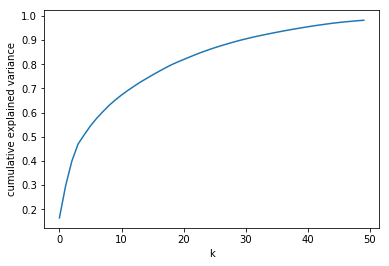

k,cumulative explained variance
0,16.40%
1,29.73%
2,39.90%
3,46.96%
4,50.83%
5,54.51%
6,57.64%
7,60.37%
8,62.99%
9,65.22%


In [22]:
def P1():
### STUDENT START ###

    # Create PCA with 50 components
    pca = PCA(n_components=50)
    # Fit the training data
    pca.fit(train_data)
    #Add up the explained variance
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
  
    # Create cev array of formated strings
    k = [k for k in range(50)]
    cev = ["{0:2.2f}%".format(cumulative_explained_variance[x]*100) for x in k ]
 
    # Plot cumulative_explained_variance
    plt.plot(k,cumulative_explained_variance)
    plt.ylabel('cumulative explained variance') 
    plt.xlabel('k')
    plt.show() 

    # list top 50 components in data frame
    df = pd.DataFrame()
    df['k'] = k
    df['cumulative explained variance'] = cev   
    display(HTML(df.to_html(index=False)))
    



### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

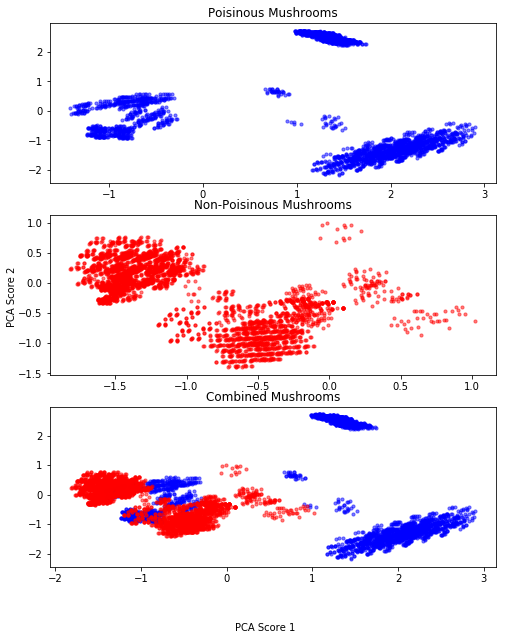

In [158]:
def P2():
### STUDENT START ###

    # Create PCA of 2 components (x,y) and fit with training data.
    pca = PCA(n_components=2).fit_transform(train_data)
    
    # setup 3X1 chart
    fig = plt.figure(figsize=(8,10))
    p1 = fig.add_subplot(3,1,1) 
    p2 = fig.add_subplot(3,1,2)
    p3 = fig.add_subplot(3,1,3)
  
    # Isolate poisinous mushrooms from training data
    pca_pos = pca[train_labels==1]
    
    # Isolate non-poisinous mushrooms from training data
    pca_zed = pca[train_labels==0]
    
    # Plot poisinous mushrooms
    p1.set_title('Poisinous Mushrooms')
    p1.scatter(pca_pos[:,0],pca_pos[:,1],s=10,c='b',alpha=0.5)    

    # Plot non-poisinous mushrooms
    p2.set_title('Non-Poisinous Mushrooms')
    p2.scatter(pca_zed[:,0],pca_zed[:,1],s=10,c='r',alpha=0.5) 

    #Plot both
    p3.set_title('Combined Mushrooms')
    p3.scatter(pca_pos[:,0],pca_pos[:,1],s=10,c='b',alpha=0.5)    
    p3.scatter(pca_zed[:,0],pca_zed[:,1],s=10,c='r',alpha=0.5) 
   
    # Add text
    fig.text(0.5, 0.04, 'PCA Score 1', ha='center', va='center')
    fig.text(0.06, 0.5, 'PCA Score 2', ha='center', va='center', rotation='vertical')

### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

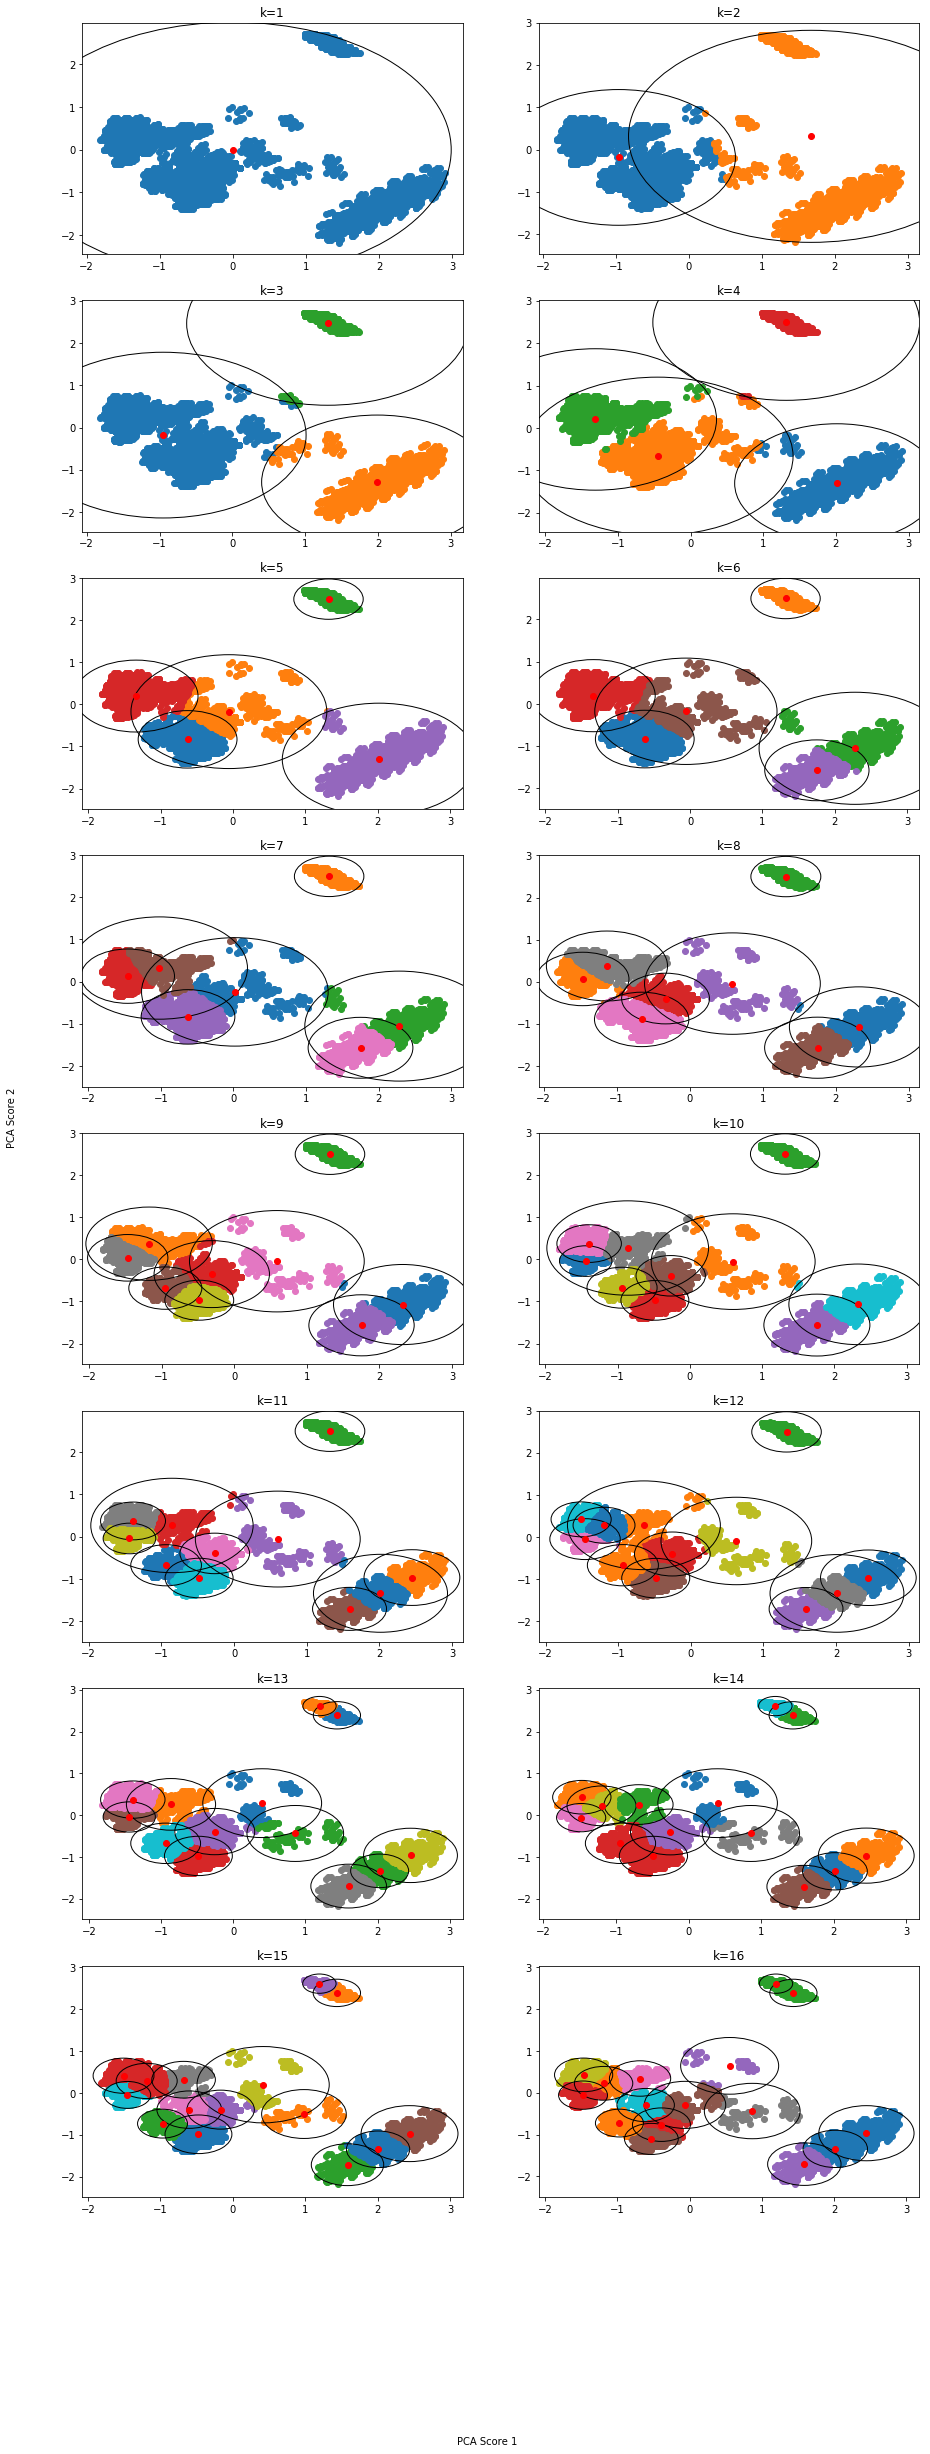

In [155]:
class PCA_KMeans(object):
    
    # CLASS ATTRIBUTES:
    # num_clusters: The number of clusters to create
    # pca: The PCA object
    # kmeans kmeans cluster object to fit PCA
    # centroid_list: ist of centroid coordinates
    # cluster_list : A list of coordinates of PCA clusters
    # max_dist_point_list : The most distant point for each k 
    # (i.e. max_dist_point[k=3] is most distant point of third centroid)
    
        def __init__(self,num_clusters):      
            # init number of clusters
            self.num_clusters = num_clusters
            
            # create 2 dimensional PCA using training data
            self.pca = PCA(n_components=2).fit_transform(train_data)
            
            # Create a kmeans model with num_clusters centroids
            self.kmeans = KMeans(n_clusters=num_clusters).fit(self.pca)
            
            # retrieve the list of centroid coordinates
            self.centroid_list = self.kmeans.cluster_centers_
            
            # create empty cluster list to fill with coordinates of cluster
            # for rendering
            self.cluster_list = list()
            
            # create empty list of most distant points per centroid
            self.max_dist_point_list = list()
            
            # For each cluster..
            for k in range(self.num_clusters):
                #retrieve the indices for the current cluster
                k_indices = np.where(self.kmeans.labels_== k)
                
                # Use indices of centroid k to extract distance from centroid in
                # transformed kmeans output
                k_dists = self.kmeans.transform(self.pca)[k_indices]
                
                # Each centroid-distance is a column.  Append the max value
                # for centroid k (located in column k)
                self.max_dist_point_list.append(np.max(k_dists[:,k]))
                
                # append the points in the pca for each cluster 
                self.cluster_list.append(self.pca[np.array(k_indices)])
                                                  
         
        # Render the lists containing cluster, centroid and max_dist info
        def render(self,plot):
            # For each cluster...
            for k in range(self.num_clusters):
                x = list()  # create empty list for x coords
                y = list()  # create empty list for y coords
                # dump x/y coordinates
                for coord in self.cluster_list[k][0]:
                    x.append(coord[0])
                    y.append(coord[1])
                    
                # Plot x and y (pca cluster for k)
                plot.scatter(x,y)
                
                # Draw centers   
                plot.plot(self.centroid_list[k][0],self.centroid_list[k][1],'ro')
              
                # draw circles
                plot.add_artist(plt.Circle((self.centroid_list[k][0],
                                          self.centroid_list[k][1]),
                                         self.max_dist_point_list[k],
                                         fill = False))
               
def P3():
    # Set plot size
    fig = plt.figure(figsize=(15,40))
    
    # repeat 16 times...
    for i in range(1,17):
        # Create PCA_KMeans with i clusters
        pkm = PCA_KMeans(i)
        
        # Add subplot
        ax = plt.subplot(8,2,i)
        
        # SEt title
        ax.set_title("k={0:}".format(i))
        
        # Render the subplot
        pkm.render(ax)
    # Add global axis labels
    fig.text(0.5, 0.04, 'PCA Score 1', ha='center', va='center')
    fig.text(0.06, 0.5, 'PCA Score 2', ha='center', va='center', rotation='vertical')


P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

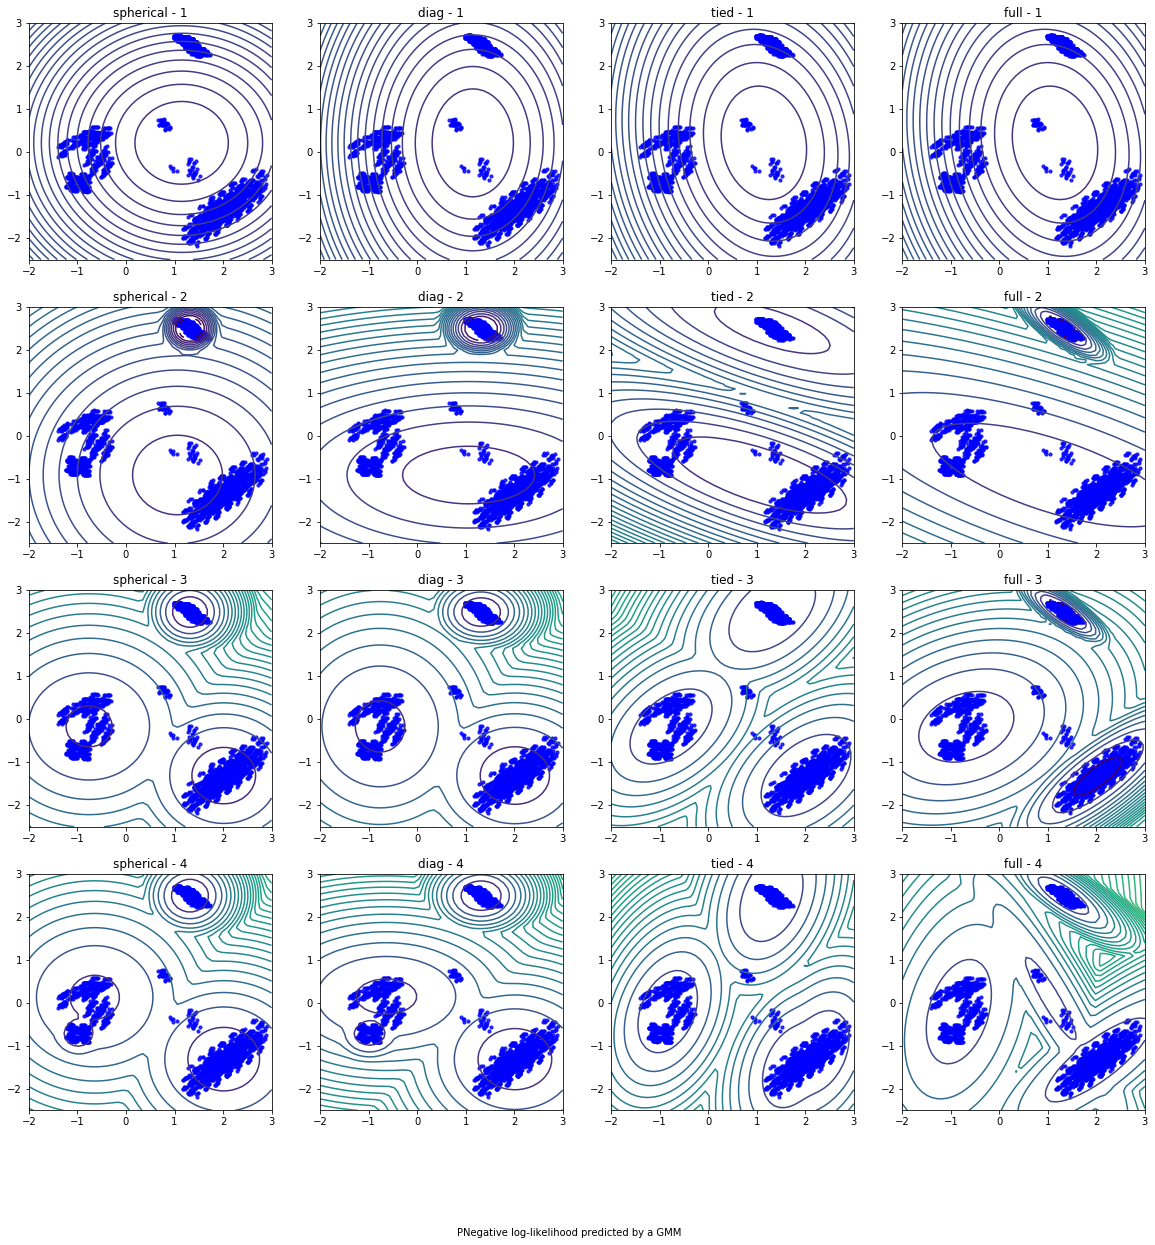

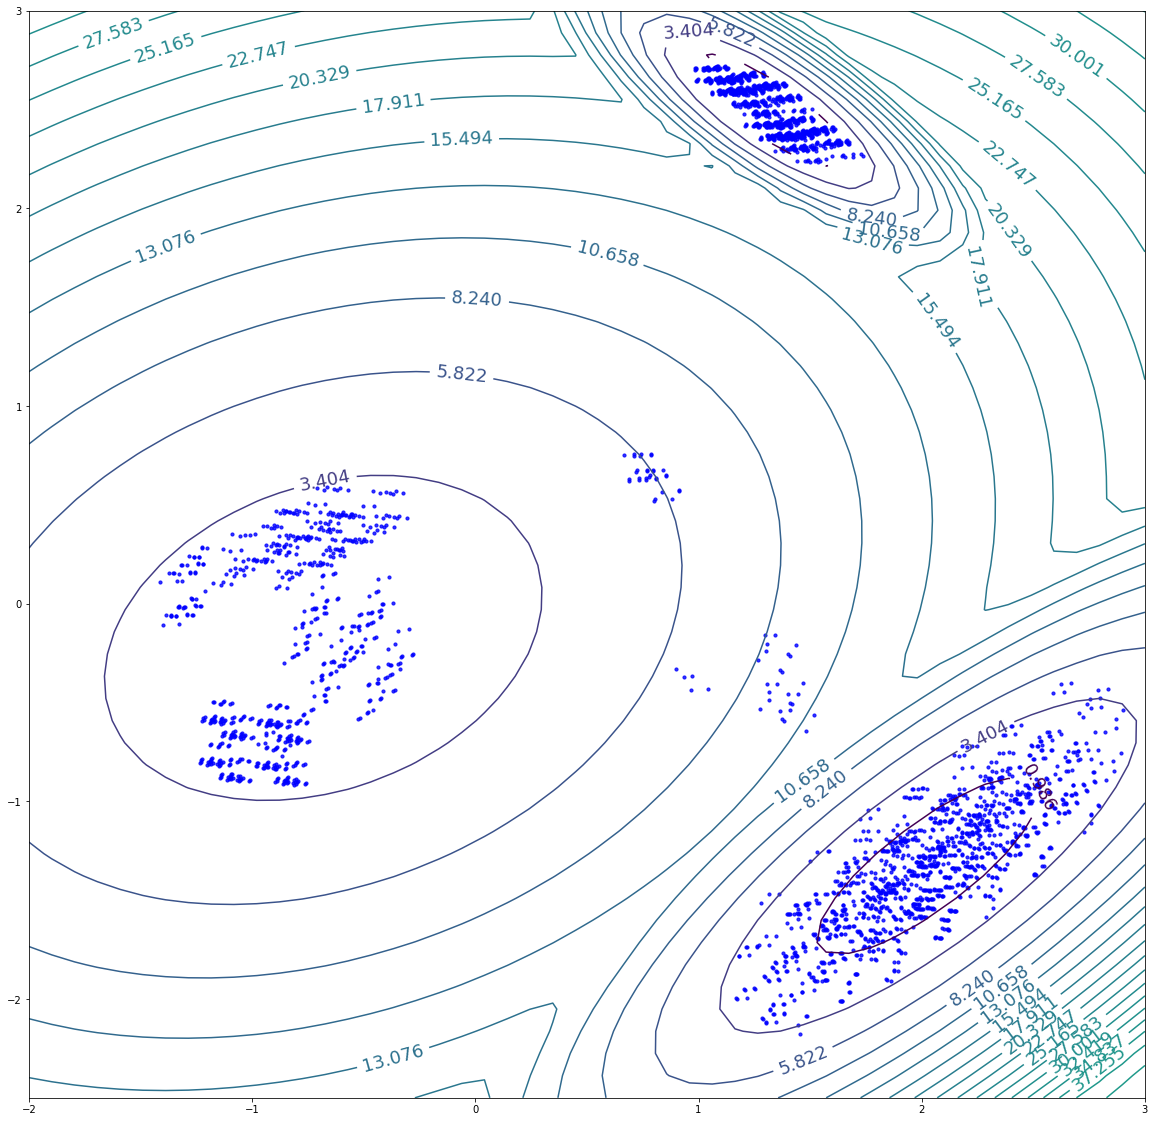

In [156]:
def P4():
### STUDENT START ###

    # Create PCA with 2 components (x,y)
    pca = PCA(n_components=2).fit_transform(train_data)
    # Identify the positive (poisinous) mushrooms
    pca_pos = pca[train_labels==1]
    # Set a large plot figure
    fig = plt.figure(figsize=(20,20))

    counter = 1
    # Repeat 4 times
    for i in range(1,5):
        # For each covariance in the list...
        for j,covariance in enumerate(('spherical', 'diag', 'tied', 'full')):   
            # fit a Gaussian Mixture Model with two components on the positive data
            clf = GaussianMixture(n_components=i, covariance_type=covariance)
            clf.fit(pca_pos)

            # display predicted scores by the model as a contour plot
            # nb -> this code mostly lifted from example.  I changed the variables
            # for aesthetics
            x = np.linspace(-2., 3.)
            y = np.linspace(-2.5, 3.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -clf.score_samples(XX)
            Z = Z.reshape(X.shape)

            ax = plt.subplot(4,4,counter)
            counter=counter+1
            # Set title of plot
            ax.set_title("{0:} - {1:}".format(covariance,i))
            # Create contour plot
            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                             levels = np.linspace(np.amin(Z), np.amax(Z), 20))
            # Create scatter plot
            plt.scatter(pca_pos[:, 0],pca_pos[:, 1],s=10,c='b',alpha= .8)

    fig.text(0.5, 0.04, 'PNegative log-likelihood predicted by a GMM', ha='center', va='center')
    plt.show()

    # Create a large image below the image matrix
    fig = plt.figure(figsize=(20,20))
    clf = GaussianMixture(n_components=3, covariance_type='full')
    clf.fit(pca_pos)

    # display predicted scores by the model as a contour plot
    x = np.linspace(-2., 3.)
    y = np.linspace(-2.5, 3.)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(XX)
    Z = Z.reshape(X.shape)

    cplt = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels = np.linspace(np.amin(Z), np.amax(Z), 20))
    plt.clabel(cplt, inline=1, fontsize=18)
    #CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(pca_pos[:, 0],pca_pos[:, 1],s=10,c='b',alpha= .8)
### STUDENT END ###
P4()   


(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [159]:
def P5():
### STUDENT START ###

    # Create 2d PCA
    pca = PCA(n_components=2)
    # Fit training data
    pca_train = pca.fit_transform(train_data)
    
    #Isolate posinous mushrooms
    pca_pos = pca_train[train_labels==1]
    
    # Isolate non-poisinous mushrooms
    pca_zed = pca_train[train_labels==0]

    # Create GMM for positive and 0 labesl
    gmm_pos = GaussianMixture(n_components=4, covariance_type='full').fit(pca_pos)
    gmm_zed = GaussianMixture(n_components=4, covariance_type='full').fit(pca_zed)

   # Transform PCA test data
    pca_test = pca.transform(test_data)
    
    # get scores for positive and zero labels on test data
    pos_score = gmm_pos.score_samples(pca_test)
    zed_score = gmm_zed.score_samples(pca_test)

    # Predictions is a list of booleans where the probability of a 1 label is greater
    # than the probability of a 0 label
    predictions = pos_score > zed_score
    
    # test_vals matches the predictions to the labels.  True if it was correct, 
    # false otherwise
    test_vals = test_labels==predictions
    
    # Accuracy is the ratio of correct values to the number of labels
    accuracy = float(np.sum(test_vals)*100)/len(test_labels)
    
    # Create a dataframe to display the results
    df2 = pd.DataFrame()
    pred = list()
    act = list()
    count = list()
    
    # Extra code here... don't want to change it now becauseit works.
    # create lists of the actual and predicted values
    for a,p in zip(test_labels[np.where(test_vals == False)],predictions[np.where(test_vals == False)[0]]):
        if a == 0:
            act.append("Not Poision")
            pred.append("Poision")
        else:
            act.append("Poision")
            pred.append("Not Poision")
    

    df2['Index'] = np.where(test_vals == False)[0]
    df2['Actual'] = act
    df2['Predicted'] = pred
    t1 = act.count("Poision")
    t2 = act.count("Not Poision")
    total_e = len(act)

    print("The accuracy is {0:2.2f}% but it only takes one poison mushroom...".format(accuracy))
    print(" of the {0:d} errors in this run, {1:d} were poisionous and labeled not poisionous".
          format(total_e,t1))

    
    display(HTML(df2.to_html(index=False)))

### STUDENT END ###
P5()

The accuracy is 93.68% but it only takes one poison mushroom...
 of the 71 errors in this run, 59 were poisionous and labeled not poisionous


Index,Actual,Predicted
78,Poision,Not Poision
104,Poision,Not Poision
107,Poision,Not Poision
116,Poision,Not Poision
120,Poision,Not Poision
121,Poision,Not Poision
126,Poision,Not Poision
143,Poision,Not Poision
164,Poision,Not Poision
169,Poision,Not Poision


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [153]:
def P6():
### STUDENT START ###

    # Calculate the total number of params
    def calc_params(pca,gmm):
        return ((pca + pca)*gmm)*2
    
    #Returns the accuracy of GMM using PCAd test data. using pca number of components
    # , gmm number of components, and the covariance specified
    def calc_accuracy(pca,gmm,covar):
            # create PCA
            pca = PCA(n_components=pca)
            #Fit against training data
            pca_train = pca.fit_transform(train_data)
            
            # Seperate poisinious (1) and non poisinous (0) training data
            pca_pos = pca_train[train_labels==1]
            pca_neg = pca_train[train_labels==0]

            # Create and fit GMM against positive and inert sets
            gmm_pos = GaussianMixture(n_components=gmm, covariance_type=covar).fit(pca_pos)
            gmm_neg = GaussianMixture(n_components=gmm, covariance_type=covar).fit(pca_neg)

           # Now score against the test data
            pca_test = pca.transform(test_data)
            pos_score = gmm_pos.score_samples(pca_test)
            neg_score = gmm_neg.score_samples(pca_test)
            
            # return the accurcy
            accuracy = float(np.sum(test_labels==(pos_score > neg_score)))/len(test_labels)
            return(accuracy)
        
    
    # we will test 20 permutations of gmm and pca components
    z = range(1,20)
    
    # create list of points satisfying <= 50 parameters
    pts = np.array([(x,y) for x in z for y in z if calc_params(x,y) <= 50 ])
    X = pts[:,0]
    Y = pts[:,1]
    Z = calc_params(X,Y)
    df = pd.DataFrame()
    df['X'] = X
    df['Y'] = Y
    df['Z'] = Z
    
    covar_list = list(['spherical', 'diag', 'tied', 'full'])
    tmp = list()
    for covar in covar_list:
        for j in range(len(X)):
            tmp.append(calc_accuracy(X[j],Y[j],covar))
        df[covar] = tmp
        tmp = list()
          
    #print(df.describe())
    cols = ['PCA','GMM','Score']
    df2 = pd.DataFrame(columns = cols,index=covar_list)
    for covar in covar_list:
        max_idx = df[covar].idxmax(1)
        df2.loc[covar] = [X[max_idx],Y[max_idx],df[covar].max()]
    
    display(HTML(df2.to_html()))
 
    

### STUDENT END ###
P6()

,PCA,GMM,Score
spherical,3,4,0.956406
diag,3,4,0.949288
tied,4,3,0.969751
full,6,2,0.966192


### 